<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/HUPV/notebooks/solutions/PSO_cv04_en_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4 - Camera Calibration

In this lab we will perform camera calibration. We will use the calibrated camera to measure distances in a plane.

## Image acquisition

To perform camera calibration you will first need to take several pictures of a calibration pattern. We will use a standard checkerboard pattern. Which you can download [here](https://raw.githubusercontent.com/kocurvik/edu/master/PSO/images/checkerboard_pattern.pdf).

*Note:* Please keep in mind that the checkerboard pattern should be planar. Ideally you should put it on a straight surface and move your camera around. It is also important that your phone does not change the focal length when capturing images. Many phones have fixed focal length cameras, but some have multiple lenses or mechanical lenses which may change focal lengths between different takes.

If you do not have your own camera feel free to use images provided at: https://raw.githubusercontent.com/kocurvik/edu/master/PSO/images/calib.zip

### Exercise 1 - Calibrate Camera and Undistort

Calibrate the camera using [the OpenCV tutorial](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html) and undistort one of the images.

In [ ]:
!wget https://github.com/kocurvik/edu/raw/master/PSO/images/calib.zip
!unzip calib.zip

import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt

--2023-10-09 14:17:12--  https://github.com/kocurvik/edu/raw/master/PSO/images/calib.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kocurvik/edu/master/PSO/images/calib.zip [following]
--2023-10-09 14:17:13--  https://raw.githubusercontent.com/kocurvik/edu/master/PSO/images/calib.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34918999 (33M) [application/zip]
Saving to: ‘calib.zip’

calib.zip           100%[===================>]  33.30M  --.-KB/s    in 0.1s    

2023-10-09 14:17:14 (223 MB/s) - ‘calib.zip’ saved [34918999/34918999]

Archive:  calib.zip
  inflating: IMG_20181018_12462512

IMG_20181018_124625122.jpg
IMG_20181018_124627291.jpg
IMG_20181018_124629779.jpg
IMG_20181018_124637823.jpg
IMG_20181018_124642449.jpg
IMG_20181018_124645144.jpg
IMG_20181018_124649042.jpg
IMG_20181018_124659162.jpg
IMG_20181018_124706096.jpg
IMG_20181018_124625122.jpg


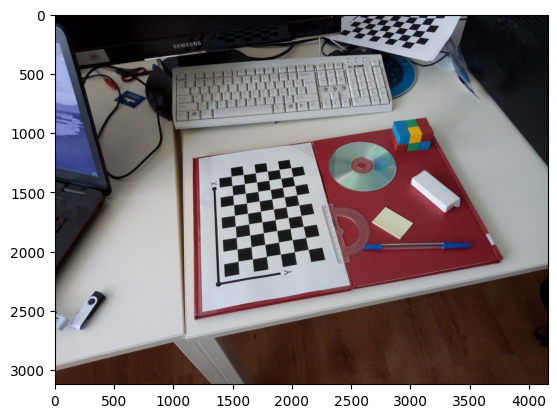

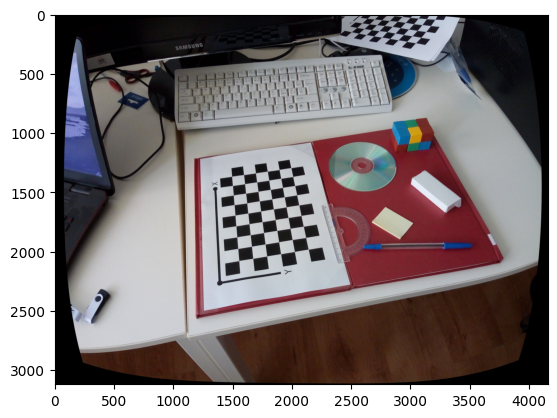

In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = sorted(glob.glob('IMG_*.jpg'))
for fname in images:
    print(fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)


ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

img = cv2.imread(images[0])
print(images[0])
h,  w = img.shape[:2]
# newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

plt.imshow(img[:, :, ::-1])
plt.show()

undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undistorted_img[:, :, ::-1])
plt.show()

## Measuring Real World Distances in a Plane

Since we have a calibrated camera we can measure distances on a plane if we know the orientation of the plane w.r.t the camera as well as at least one distance measurement within the plane.

*Note:* For simplicity we will assume that we are interested in measuring one of the images that we also used for calibration. In that case we will already have the rotation and translation of the checkerboard plane available to us as it was calculated during the calibration process. We will also have the detected positions of the checkerboard corners available. If you want to perform this on a different image you can use the OpenCV `solvePnP` method to obtain the rotation vector given the corner points detected by the methods `findChessboardCorners` and `cornerSubPix`. If you finish this exercise early feel free to try and implement an approach which uses these methods and does not require the image to be a part of the calibration set.

The following code will provide you with a so-called homography matrix. The matrix enables us to convert the points from the undistorted image such that we the plane normal is parallel to the optical axis of the camera.

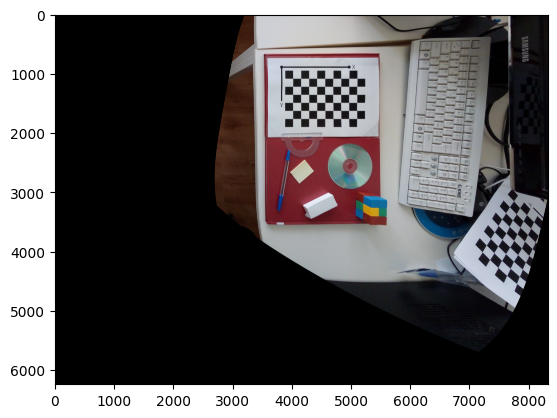

In [ ]:
def get_rectification_homography(cameramtx, rvec):
  R = cv2.Rodrigues(rvec)[0]
  H = cameramtx @ np.eye(3) @ np.linalg.inv(cameramtx @ R)
  return H

# we can use the homography to change the perspective of the image
H = get_rectification_homography(mtx, rvecs[0])
# undistorted_img is the output of cv2.undistort
img_warp = cv2.warpPerspective(undistorted_img, H, (2*undistorted_img.shape[1], 2*undistorted_img.shape[0]))
plt.imshow(img_warp[:, :, ::-1])
plt.show()

### Exercise 2 - Distance of Objects in a Plane

Since we now have the homography matrix available. We can also warp individual points. We can use this to calculate the distance of two points on the image by comparing the distance to some other two points whose ditances we already know.

Keep in mind that you have to first undo the distortion. So you have to first use the OpenCV `undistort` or the `undistortImagePoints` method and then the `perspectiveTransform` method, which uses the homography matrix.

Now implement code that displays either the undistorted, distorted image or the rectified image and lets the user click on two points. The user should then get an information on how far the objects are provided that they are on the same plane as the checkerboard. Note that the size of one of the checkerboard squares is 22 mm. You will need to use different processing steps based on which image you display.


*Note:* We are still assuming that the image was part of the set of images we used to calibrate the camera. Feel free to implement a version which does not require this if you finished early - see note in the cell above.

In [ ]:
!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.8 MB/s eta 0:00:00


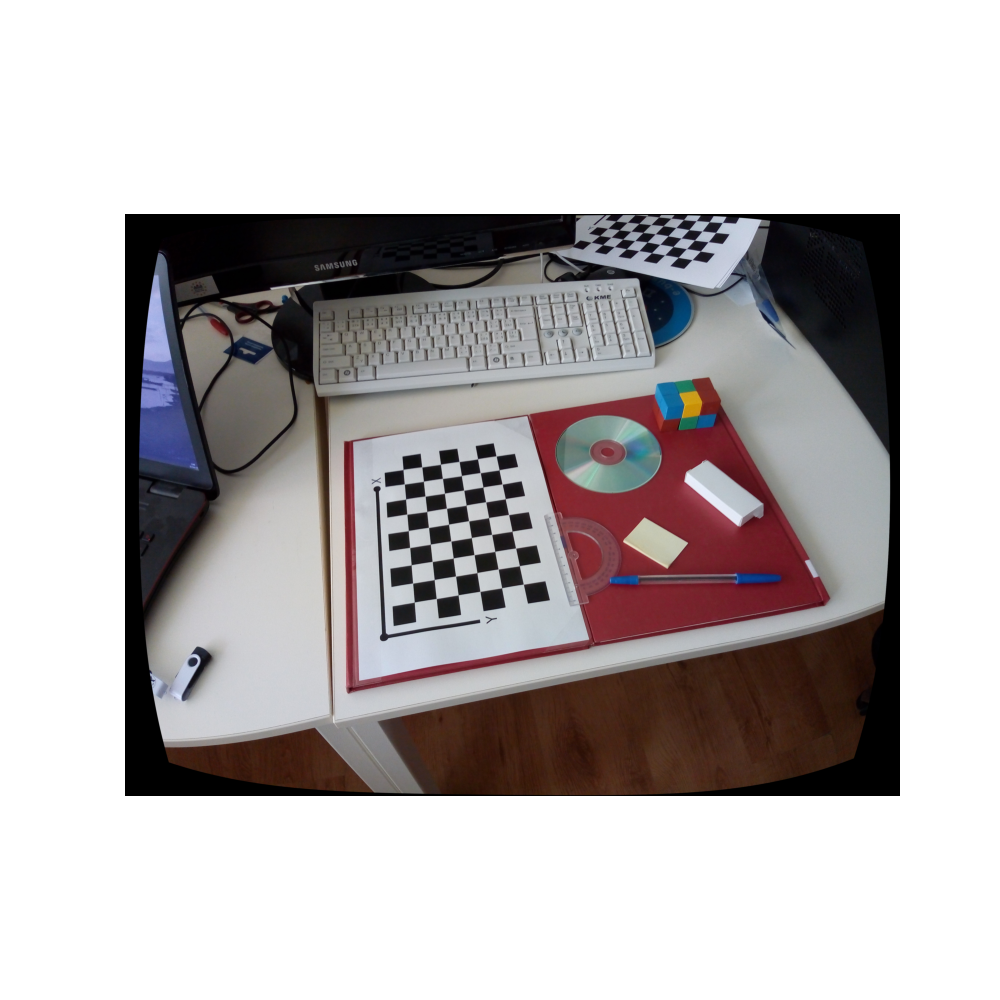

Upper Left Corner Selected
Lower Right Corner Selected


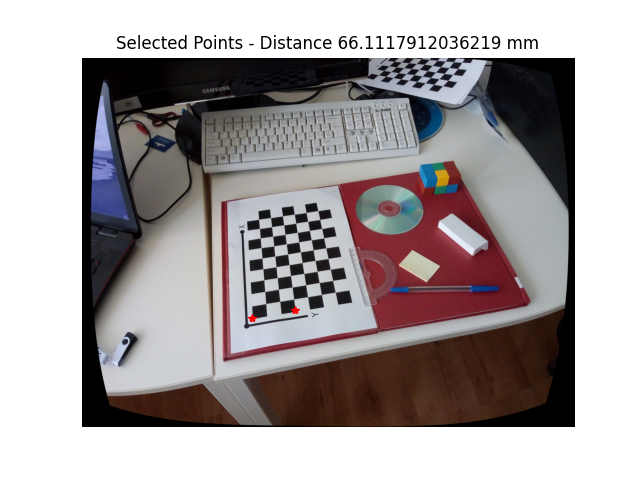

Upper Left Corner Selected
Lower Right Corner Selected


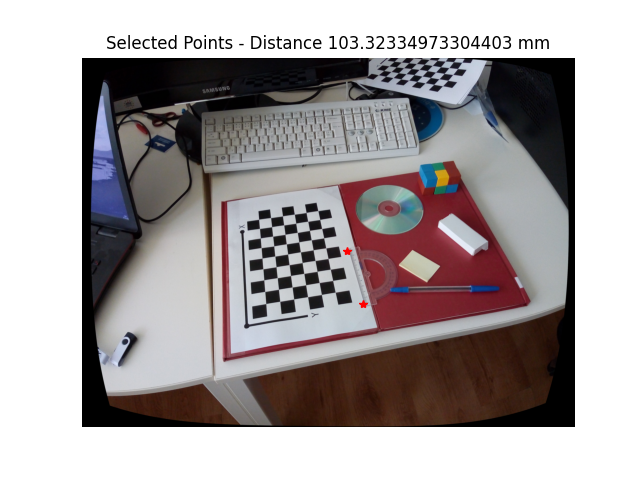

Upper Left Corner Selected
Lower Right Corner Selected


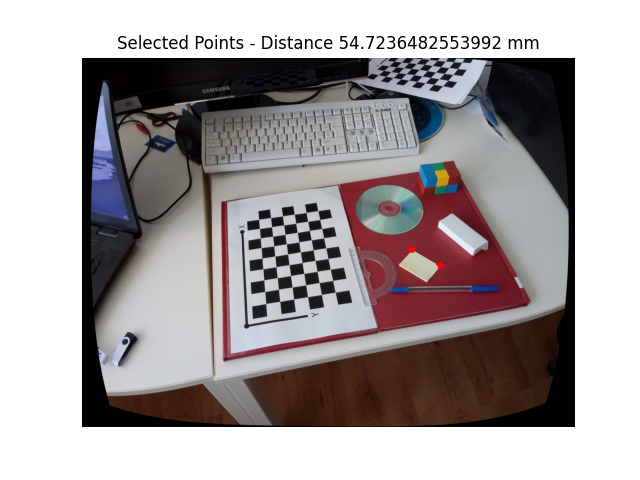

Upper Left Corner Selected
Lower Right Corner Selected


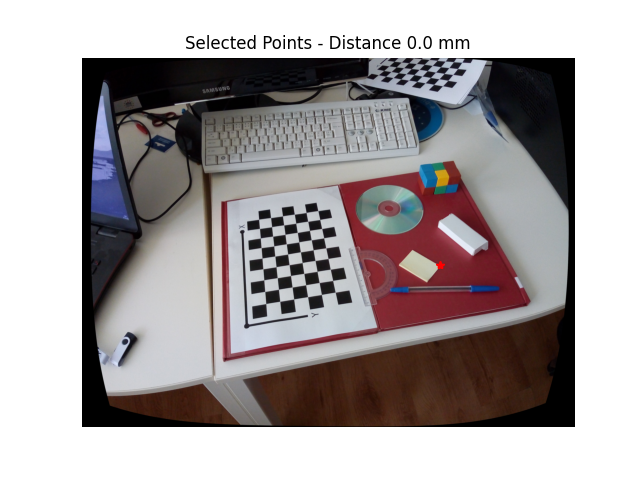

In [ ]:
import matplotlib
import matplotlib.pyplot as plt


plt.close('all')
fig = plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(undistorted_img[:, :, ::-1])
plt.show()

corner_pts = imgpoints[0]
corner_pts_undistorted = cv2.undistortImagePoints(corner_pts[:2, 0, :], mtx, dist)
warp_corner_pts = cv2.perspectiveTransform(corner_pts_undistorted, H)
corner_dist = np.linalg.norm(warp_corner_pts[0, 0] - warp_corner_pts[1, 0])

points = []

def calc_distance():
  pts = np.array(points)
  warp_pts = cv2.perspectiveTransform(pts[:, np.newaxis, :], H)
  dist = 22 * np.linalg.norm(warp_pts[0, 0, :] - warp_pts[1, 0, :]) / corner_dist

  plt.figure()
  plt.imshow(undistorted_img[:, :, ::-1])
  plt.plot(pts[:, 0], pts[:, 1], 'r*')
  plt.title('Selected Points - Distance {} mm'.format(dist))
  plt.axis('off')
  plt.show()

def onclick(event):
    if len(points) >= 2:
        points.clear()
    ix, iy = event.xdata, event.ydata
    points.append((ix, iy))
    if len(points) == 1:
      print("Upper Left Corner Selected")
    if len(points) == 2:
      print("Lower Right Corner Selected")
      calc_distance()

cid = fig.canvas.mpl_connect('button_press_event', onclick)